In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_moons, make_classification, make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from ISLP import load_data

# Prevent warnings 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Q4
Generate a simulated two-class data set with 100 observations and two features in which there is a visible but non-linear separation between the two classes. Show that in this setting, a support vector machine with a polynomial kernel (with degree greater than 1) or a radial kernel will outperform a support vector classifier on the training data. Which technique performs best on the test data? Make plots and report training and test error rates in order to back up your assertions.

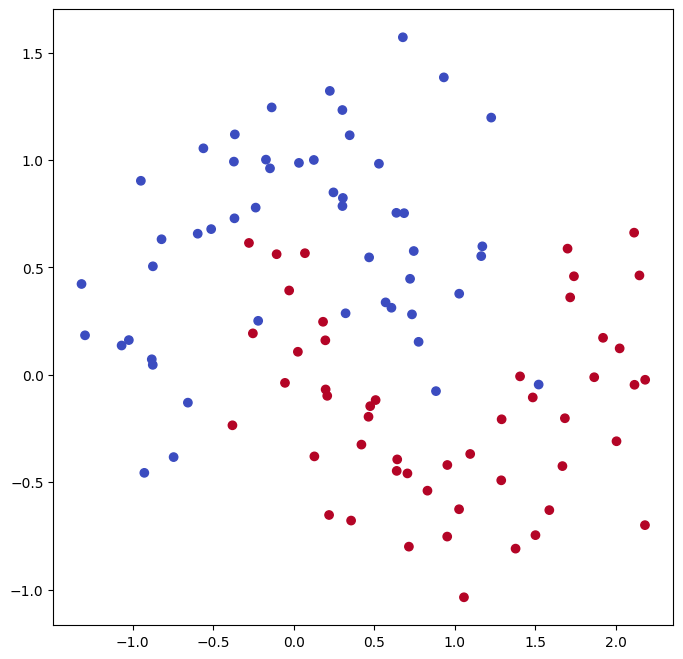

In [2]:
# Generate training data with parabolic boundary 
X, y = make_moons(n_samples=100, noise=0.3, random_state=0, shuffle=True) # Makes 2 interleaving circles 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Plot the results 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [3]:
# Define a function to find & plot results of different models 

def results(model):
    # Fit the model on training data 
    model.fit(X_train, y_train)

    # Find training and testing error
    tr_pred = model.predict(X_train)
    te_pred = model.predict(X_test)
    
    tr_acc = accuracy_score(tr_pred, y_train)
    te_acc = accuracy_score(te_pred, y_test)
    
    print(f"Training accuracy is {np.round(tr_acc,2)}")
    print(f"Testing accuracy is {np.round(te_acc,2)}")
    
    # Plot all observations  
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-2, 3)
    ax.set_ylim(-2, 3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    # Plot the decision boundary
    DecisionBoundaryDisplay.from_estimator(model, X_train, response_method="predict", plot_method="contour", ax=ax)
    plt.show()

Training accuracy is 0.83
Testing accuracy is 0.87


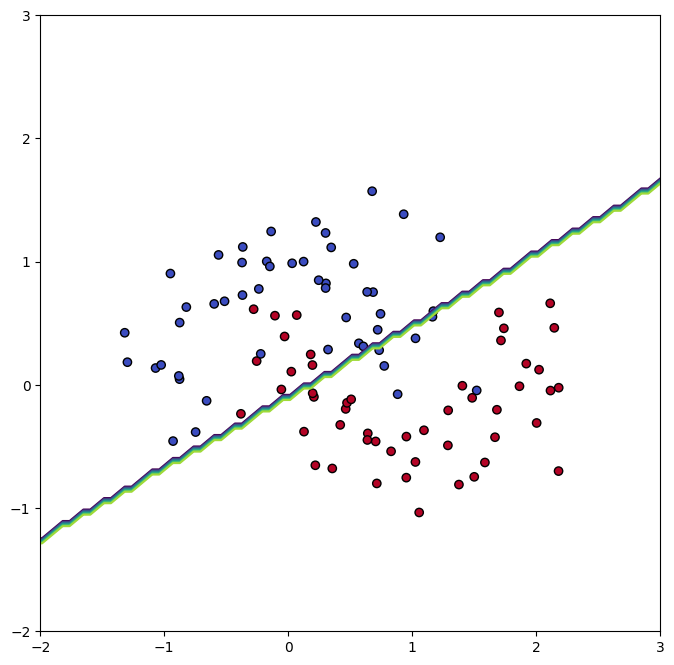

In [4]:
linear_model = SVC(C=1, kernel='linear', random_state=0)
results(linear_model)

Training accuracy is 0.84
Testing accuracy is 0.77


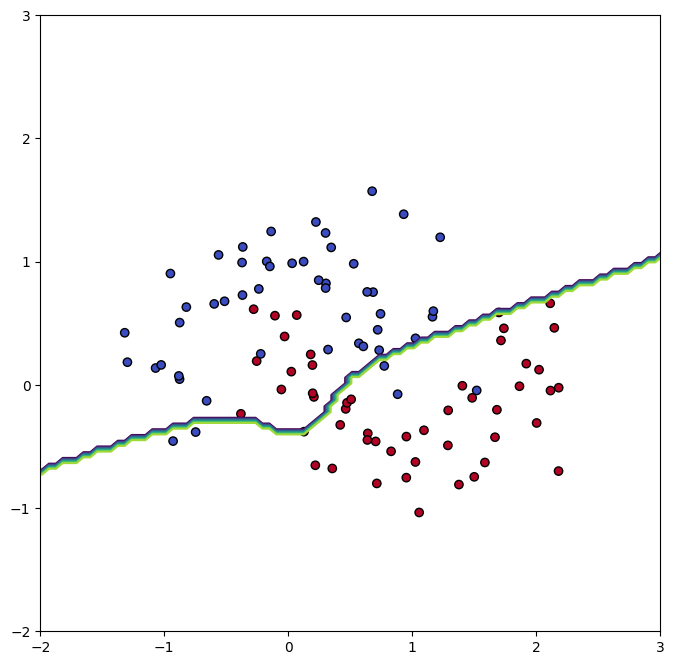

In [5]:
poly_model = SVC(C=10, kernel='poly', degree=3, random_state=0)
results(poly_model)

Training accuracy is 0.93
Testing accuracy is 0.93


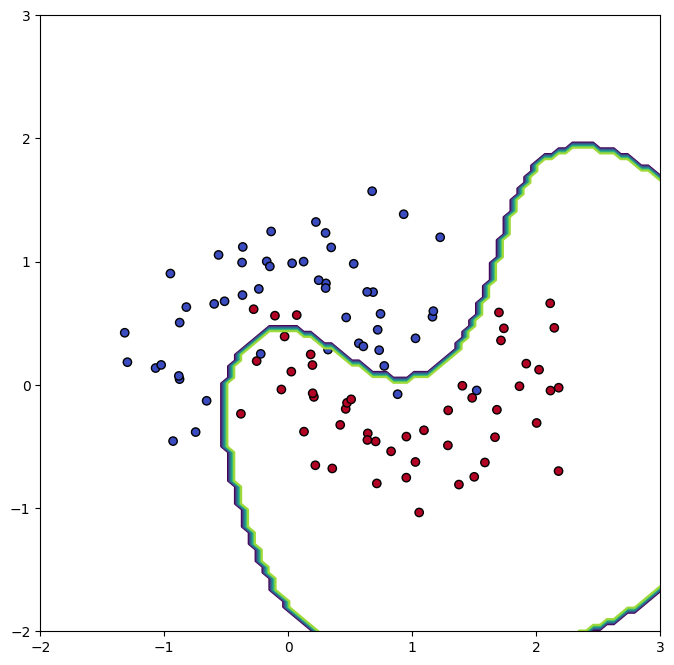

In [6]:
rad_model = SVC(C=1, gamma=1, kernel='rbf', random_state=0)
results(rad_model)

>- The radial kernel out performs both models.
>- **Note** : The polynomial kernel was failing miserably with C=1. Each of these methods have different hyper-parameters and differing values will cause differing performances. To find the optimal values, always cross-validate.

#### Q6
At the end of Section 9.6.1, it is claimed that in the case of data that is just barely linearly separable, a support vector classifier with a small value of C that misclassifies a couple of training observations may perform better on test data than one with a huge value of C that does not misclassify any training observations. You will now investigate this claim.

(a) Generate two-class data with p = 2 in such a way that the classes are just barely linearly separable.

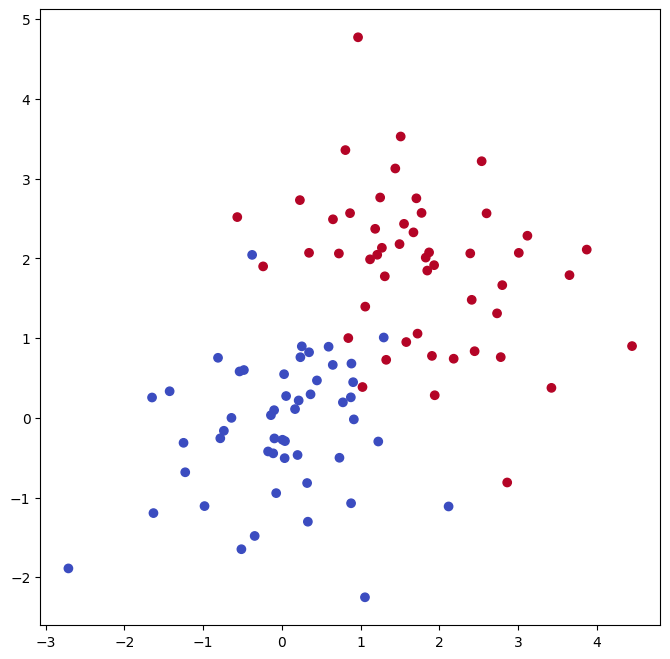

In [7]:
# Generate training data with linear boundary 
rng = np.random.default_rng(1)
X = rng.standard_normal((100, 2))
y = np.array([-1]*50+[1]*50)
X[y==1] += 1.9
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Plot the results 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

(b) Compute the cross-validation error rates for support vector classifiers with a range of C values. How many training observations are misclassified for each value of C considered, and how does this relate to the cross-validation errors obtained?

(c) Generate an appropriate test data set, and compute the test errors corresponding to each of the values of C considered. Which value of C leads to the fewest test errors, and how does this compare to the values of C that yield the fewest training errors and the fewest cross-validation errors?

In [8]:
c_values = np.linspace(0.01,10,10)
results = pd.DataFrame(columns=['C', 'Missed', 'CVA','TRA','TEA'])
for c_i in c_values:
    # Define support vector classifier for each C value
    model = SVC(C=c_i, kernel='linear', random_state=0)  
    # Find 10 fold cross validation error 
    cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy') 
    cv_acc = np.mean(cv_scores)
    # Fit model and make predictions
    model.fit(X_train, y_train)
    tr_pred = model.predict(X_train)
    te_pred = model.predict(X_test)
    # No. of misclassified training points 
    mc = (tr_pred != y_train).sum()
    # Training and testing error 
    tr_acc = accuracy_score(tr_pred, y_train)
    te_acc = accuracy_score(te_pred, y_test)
    # Add all the values in new row & add results 
    new_row = pd.DataFrame({'C': [c_i], 'Missed': [mc],  'CVA': [cv_acc], 
                            'TRA': [np.round(tr_acc,2)], 'TEA':[np.round(te_acc,2)]})
    results = pd.concat([results, new_row], ignore_index=True)

results

,C,Missed,CVA,TRA,TEA
0,0.01,2,0.95,0.97,0.93
1,1.12,2,0.95,0.97,0.97
2,2.23,1,0.93,0.99,0.93
3,3.34,1,0.93,0.99,0.93
4,4.45,1,0.93,0.99,0.93
5,5.56,1,0.93,0.99,0.93
6,6.67,1,0.93,0.99,0.93
7,7.78,1,0.93,0.99,0.93
8,8.89,1,0.93,0.99,0.93
9,10.00,1,0.93,0.99,0.93


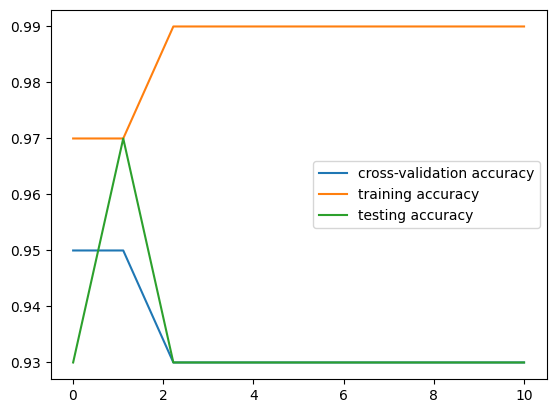

In [9]:
f, ax = plt.subplots(1)

ax.plot(results['C'], results['CVA'], label='cross-validation accuracy')
ax.plot(results['C'], results['TRA'], label='training accuracy')
ax.plot(results['C'], results['TEA'], label='testing accuracy')
ax.legend();

(d) Discuss your results.

>- The test accuracy & cross-validation accuracy is highest when c=1. As the value of c is increased, they decreases and plateau, indicating over-fitting.
>- After c=2 the training accuracy is near perfect and doesn't change, irrespective of the cost.
>- Based on the results obtained it is confirmed that a lower value of C (more biased & broader margin) has higher accuracy on testing data, when compared to a large value of C (more variance & narrower margin). Hence allowing some misclassification is a better strategy.   